# Market Basket: case description

The manager of a grocery store asked for your help regarding the shelf layout of the shop. Until recently they
had about 200 SKUs (stock keeping units: unique item numbers), but the headquarter of the grocery chain
advised them to keep only 105 of them and introduce 64 new SKUs. The store manager is in charge of
where to place those items. You find the layout of the shop on the next page. The 105 existing items were
distributed evenly across the 7 shelves. In general everything can be changed, but the store manager
suggests to keep those 105 items at their current position, unless there are very strong reasons for an
alternative. Otherwise the customers could be even more confused than they will be anyway due to the
change.



You have been given sales data from a different shop that made the transition last year. The layout of this
shop is somewhat different, but you can get from the data, which items were purchased together and which
not.


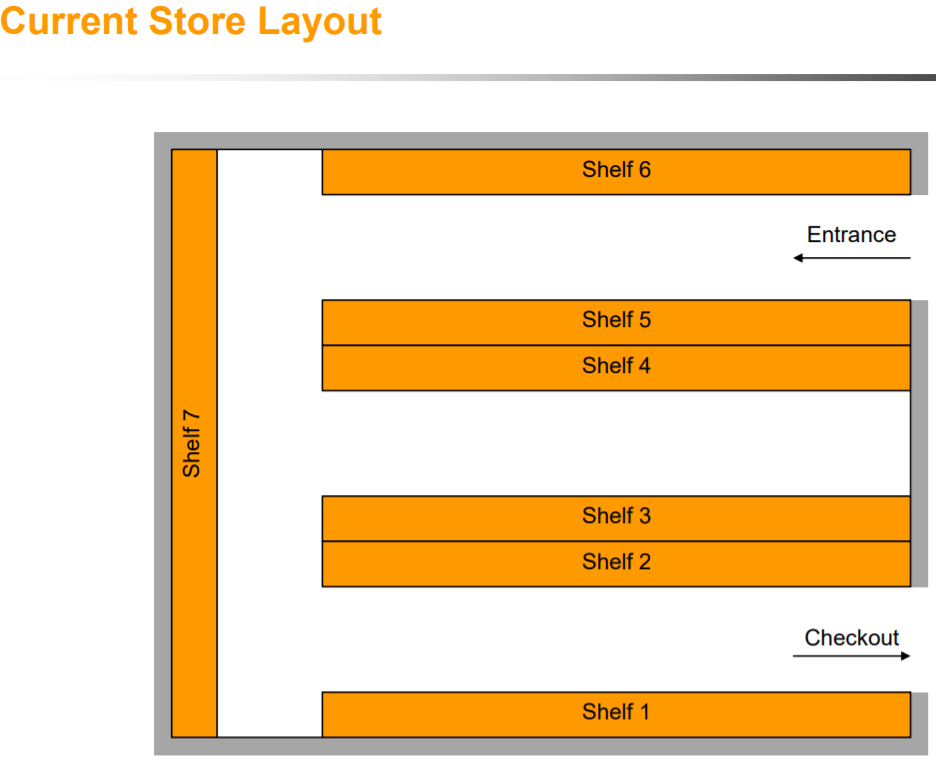![image.png]()

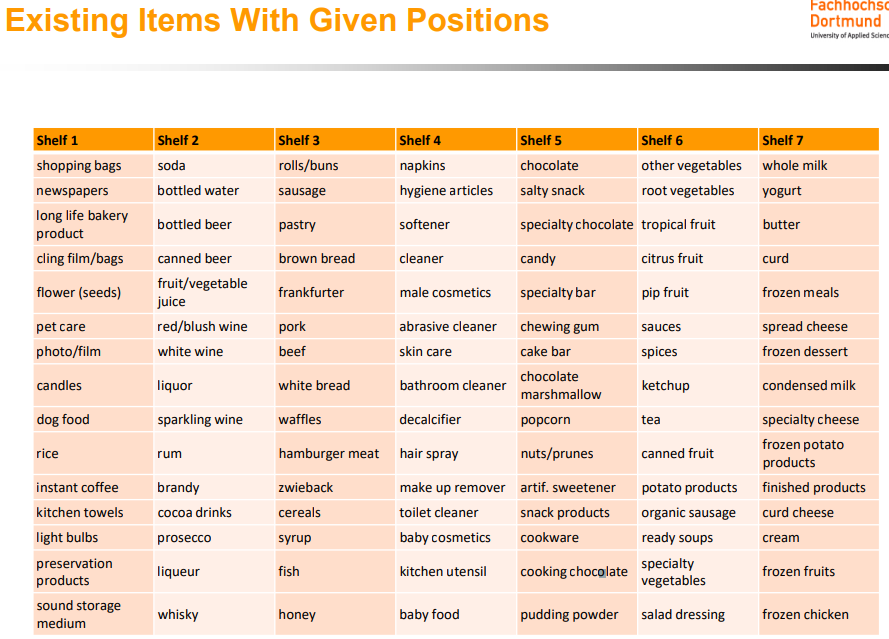

## Packages

In [1]:
!pip install seaborn -q
!pip install plotnine -q

In [2]:
import io
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from collections import OrderedDict
from plotnine import *

import matplotlib.pyplot as plt
%matplotlib inline

# Utils

In [3]:
def load_dataset(url, sep=',', decode='utf-8', dtype=None, header=None):
    """Requesting url dataset
    
    Args:
        url: with the dataset
        sep: select the dataset separator
    
    Returns:
        a requested and decoded url
    """

    def requests_csv(url, decode='utf-8'):
        return (requests.get(url).content.decode(decode))
    
    return pd.read_csv(io.StringIO(requests_csv(url, decode)), sep=sep, dtype=dtype, header=header)

In [4]:
def create_association_dataset(data_support, verbose=None, fill_value=0):
    """A function that return lift or leverage dataset based on association rules. 
    
    Args:
        data_support: support dataframe = `data_freq / N`.
        verbose: 0 or 1. Verbosity mode. 0 = lift, 1 = leverage.
        fill_value: fill empty values.

    Returns:
        a dataframe based in the association rules (lift or leverage)
    """

    data_func = data_support.copy()
    for i in data_support.keys():
        for j in data_support.keys():
            if i == j:
                data_func.loc[i,j] = fill_value
            else:
                if verbose == 0: # lift
                    data_func.loc[i,j] = (data_support.loc[i,j]) / (data_support.loc[i,i]*data_support.loc[j,j])
                elif verbose == 1: # leverage
                    data_func.loc[i,j] = data_support.loc[i,j] - (data_support.loc[i,i] * data_support.loc[j,j])
    return data_func

In [5]:
def shelf_func(item):
    if item in placed_items:
        if item in shelf1:
            shelf = "shelf 1"
        elif item in shelf2:
            shelf = "shelf 2"
        elif item in shelf3:
            shelf = "shelf 3"
        elif item in shelf4:
            shelf = "shelf 4"
        elif item in shelf5:
            shelf = "shelf 5"
        elif item in shelf6:
            shelf = "shelf 6"
        elif item in shelf7:
            shelf = "shelf 7"
    elif item in unplaced_items:
        shelf = "no shelf"
    elif item == None:
        return None
    return shelf

In [6]:
def convert_rules_scales(df: pd.core.frame.DataFrame, rule_min: int, rule_max: int, subset: str, digits_line=3):
    """Convert any scale to the support scale, which is between the range 0 and 1.

    Args:
        df      : dataframe with the association rule subset that we want to change
        rule_min: minumun value from the association rule
        rule_max: maximum value from the association rule
        subset  : column which contain the elements from the association rule
        digits  : digits to round the function of the line (`func_rec`)
    """
    sup_values = {'min': 0, 'max': 1}

    def func_rec(m, x, b):
        if x != 0:
            return round(m * x + b, digits_line)
        else:
            return 0.0

    def func_pend(x1, x2, y1, y2):
        return (y2 - y1) / (x2 - x1)

    def func_b(x, y, m):
        return y - m * x
    
    rule_pend  = func_pend(x1=rule_min, y1=sup_values['min'], x2=rule_max, y2=sup_values['max']) 

    # i.e. association rules: subset = "leverage" or "lift"
    df[subset] = df[subset].apply(lambda i: func_rec(m=rule_pend, b=func_b(x=rule_max, y=sup_values['max'], m=rule_pend), x=i))

    return df

# Dataset

* 9835 rows
* Each row is a transaction (customer basket)
* The items purchased in each
row are separated by commas
* 169 unique items## Data Import

We import the csv file with the information of 9836 transactions.

## Load the dataset

In [7]:
raw_url = 'https://raw.githubusercontent.com/Y4rd13/ILIAS/main/datasets/W02_data_groceries.csv'
df = load_dataset(url=raw_url, sep='\t', header=None)

In [8]:
df

,0
0,"citrus fruit,semi-finished bread,margarine,rea..."
1,"tropical fruit,yogurt,coffee"
2,whole milk
3,"pip fruit,yogurt,cream cheese,meat spreads"
4,"other vegetables,whole milk,condensed milk,lon..."
...,...
9830,"sausage,chicken,beef,hamburger meat,citrus fru..."
9831,cooking chocolate
9832,"chicken,citrus fruit,other vegetables,butter,y..."
9833,"semi-finished bread,bottled water,soda,bottled..."


## Some preprocessing

In [9]:
df.columns = ['transaction']
df['id'] = range(len(df))
df = df[['id', 'transaction']]

In [10]:
df.head(10)

,id,transaction
0,0,"citrus fruit,semi-finished bread,margarine,rea..."
1,1,"tropical fruit,yogurt,coffee"
2,2,whole milk
3,3,"pip fruit,yogurt,cream cheese,meat spreads"
4,4,"other vegetables,whole milk,condensed milk,lon..."
5,5,"whole milk,butter,yogurt,rice,abrasive cleaner"
6,6,rolls/buns
7,7,"other vegetables,UHT-milk,rolls/buns,bottled b..."
8,8,potted plants
9,9,"whole milk,cereals"


In [11]:
transaction_id = df['id'].values.tolist()
items_purchased = df['transaction'].values.tolist()
items_purchased = [i.split(',') for i in items_purchased]

d_data = dict(zip(transaction_id, items_purchased))

In [12]:
list(d_data.items())[:5]

[(0, ['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']),
 (1, ['tropical fruit', 'yogurt', 'coffee']),
 (2, ['whole milk']),
 (3, ['pip fruit', 'yogurt', 'cream cheese', 'meat spreads']),
 (4,
  ['other vegetables',
   'whole milk',
   'condensed milk',
   'long life bakery product'])]

In [13]:
list(d_data.values()).count((list(d_data.values())[0][:2]))

1

In [14]:
list(d_data.values())[0]

['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']

In [15]:
(list(d_data.values())[0][:2])

['citrus fruit', 'semi-finished bread']

## Data Processing

We create a dictionary **frequency_dict** which contains 169 keys, one for each unique item and 9836 values in each key. The values in each key is a list of 9836 elements, where there is a 1 if that item was bought in that transaction or a 0 if that item wasn't bought in that transaction.

We can see a simple example to show what we are doing.

In [16]:
# Constants
N = len(df) # Number of transactions
UNIQUE_ITEMS = set([x for b in d_data.values() for x in b]) #SKUs
UNIQUE_ITEMS_LEN = len(UNIQUE_ITEMS)

In [17]:
SKUs = UNIQUE_ITEMS
baskets = items_purchased

frequency_dict = dict()
for item in SKUs:
    freq = list()
    for trans in baskets:
        if item in trans:
            freq.append(1)
        else:
            freq.append(0)
    frequency_dict[str(item)] = freq

We can check that there are 169 different keys and in the *Instant food products* key there are 9836 values that can take 0 or 1 value.

In [18]:
print(len(frequency_dict.keys()))
print(len(frequency_dict['Instant food products']))

169
9835


We can have that information in a pandas Data Frame, getting 169 columns (one for each item) and 9836 rows (one for each transaction).

In [19]:
data = pd.DataFrame(frequency_dict)
data

,soft cheese,root vegetables,baby cosmetics,rolls/buns,candy,specialty bar,fruit/vegetable juice,cocoa drinks,specialty chocolate,packaged fruit/vegetables,bathroom cleaner,processed cheese,whipped/sour cream,frozen fish,beef,beverages,ham,herbs,meat spreads,onions,soda,shopping bags,nut snack,dog food,snack products,sausage,baby food,flower (seeds),liver loaf,rice,cereals,pip fruit,soups,kitchen towels,spices,skin care,brandy,hygiene articles,sugar,cling film/bags,...,margarine,frozen dessert,light bulbs,pasta,canned fruit,butter,canned fish,oil,condensed milk,bottled beer,liquor (appetizer),chicken,dish cleaner,bags,frankfurter,candles,red/blush wine,cleaner,tidbits,sliced cheese,preservation products,mayonnaise,liqueur,cake bar,jam,dessert,canned vegetables,UHT-milk,female sanitary products,newspapers,cookware,specialty vegetables,ready soups,sauces,rubbing alcohol,frozen fruits,tea,softener,whole milk,toilet cleaner
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9830,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9831,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9832,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9833,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


If we sum the values in the columns we get the frequency for each item. This is an important value to calculate later metrics. We save this information as **one_item_freq**. For example, this values are used if we calculate the **support** for item X.

$$Support(X)=\frac{Frequency(X)}{N}$$

We can also get the total number of transactions $N$.

In [20]:
one_item_freq = data.sum()
one_item_freq

soft cheese         168
root vegetables    1072
baby cosmetics        6
rolls/buns         1809
candy               294
                   ... 
frozen fruits        12
tea                  38
softener             54
whole milk         2513
toilet cleaner        7
Length: 169, dtype: int64

In [21]:
N = data.shape[0]
N

9835

To calculate and get other metrics like $Support(X\rightarrow Y)$, $Confidence(X\rightarrow Y)$, $Lift(X\rightarrow Y)$ and $Leverage(X\rightarrow Y)$ we need to calculate the two items frequency $Frequency(X \& Y)$. We can obtain this information doing some matrix calculations. The first step is to transform the **data** dataframe in a matrix (numpy array). 

In [22]:
data_matrix = data.to_numpy()
print(data_matrix.shape)
print(type(data_matrix))

(9835, 169)
<class 'numpy.ndarray'>


We have a 9836 x 169 matrix. If we make the matrix product between this matrix and the same matrix transposed we obtain a 169 x 169 matrix. We call this matrix **freq_matrix** as it shows the one-item frequencies in it's diagonal and the two-item frequencies in the other positions.

In [23]:
freq_matrix = data_matrix.transpose() @ data_matrix
freq_matrix

array([[ 168,   33,    0, ...,    1,   74,    0],
       [  33, 1072,    1, ...,    8,  481,    2],
       [   0,    1,    6, ...,    0,    3,    0],
       ...,
       [   1,    8,    0, ...,   54,   21,    0],
       [  74,  481,    3, ...,   21, 2513,    2],
       [   0,    2,    0, ...,    0,    2,    7]])

## Frequency Dataframe

We can transform this numpy array into a dataframe, we call it **data_freq** and we can set back the proper column and row names, which are the 169 items.

In [24]:
data_freq = pd.DataFrame(freq_matrix)
data_freq.index = one_item_freq.index
data_freq.columns = one_item_freq.index
data_freq

,soft cheese,root vegetables,baby cosmetics,rolls/buns,candy,specialty bar,fruit/vegetable juice,cocoa drinks,specialty chocolate,packaged fruit/vegetables,bathroom cleaner,processed cheese,whipped/sour cream,frozen fish,beef,beverages,ham,herbs,meat spreads,onions,soda,shopping bags,nut snack,dog food,snack products,sausage,baby food,flower (seeds),liver loaf,rice,cereals,pip fruit,soups,kitchen towels,spices,skin care,brandy,hygiene articles,sugar,cling film/bags,...,margarine,frozen dessert,light bulbs,pasta,canned fruit,butter,canned fish,oil,condensed milk,bottled beer,liquor (appetizer),chicken,dish cleaner,bags,frankfurter,candles,red/blush wine,cleaner,tidbits,sliced cheese,preservation products,mayonnaise,liqueur,cake bar,jam,dessert,canned vegetables,UHT-milk,female sanitary products,newspapers,cookware,specialty vegetables,ready soups,sauces,rubbing alcohol,frozen fruits,tea,softener,whole milk,toilet cleaner
soft cheese,168,33,0,53,5,9,27,2,13,3,0,7,30,5,24,6,17,4,1,17,27,28,0,1,0,34,1,3,3,4,2,29,4,5,1,1,0,9,11,3,...,22,2,0,9,0,27,7,13,4,12,1,19,7,0,22,5,2,0,1,18,0,4,0,3,3,18,3,5,0,13,0,3,0,2,0,1,1,1,74,0
root vegetables,33,1072,1,239,42,21,118,4,33,34,8,31,168,26,171,31,36,69,4,93,183,126,6,14,4,147,0,19,14,31,13,153,17,13,9,7,7,53,63,16,...,109,24,5,38,7,127,26,69,15,95,7,107,16,1,100,17,25,8,0,55,0,25,1,18,19,57,26,48,9,113,4,4,4,8,4,3,8,8,481,2
baby cosmetics,0,1,6,2,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,2,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,3,0
rolls/buns,53,239,2,1809,70,55,143,5,55,26,6,46,144,24,134,53,68,30,13,67,377,192,6,13,11,301,1,18,15,15,11,137,13,12,11,14,11,58,69,19,...,145,29,7,24,6,132,40,50,22,134,9,95,22,1,189,13,39,7,12,75,0,27,3,31,13,67,21,63,16,194,6,2,9,8,1,2,11,9,557,0
candy,5,42,0,70,294,15,39,2,23,8,2,16,35,10,12,7,13,7,1,9,85,44,1,1,4,36,0,5,0,3,2,23,2,2,3,2,1,10,16,6,...,29,7,2,7,2,28,5,15,3,14,5,21,6,0,22,4,8,3,1,8,1,7,0,9,5,14,5,12,1,22,2,1,0,3,1,1,0,1,81,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
frozen fruits,1,3,0,2,1,1,1,1,2,0,0,3,6,1,2,0,0,1,0,1,3,4,0,2,0,0,0,0,0,0,2,1,0,1,0,0,0,0,1,0,...,2,0,0,0,0,2,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,3,0
tea,1,8,0,11,0,1,7,1,0,1,1,2,5,1,3,2,2,0,0,5,3,4,0,0,1,4,0,1,0,1,0,8,1,1,0,0,0,4,2,4,...,4,1,1,1,1,6,3,3,0,11,0,0,0,0,4,1,1,1,0,1,0,1,0,0,0,5,2,1,0,4,0,0,0,0,0,0,38,0,16,0
softener,1,8,0,9,1,2,4,0,1,1,0,1,9,1,1,0,3,0,0,0,11,11,0,2,0,10,0,3,1,2,0,11,1,2,0,0,1,8,1,1,...,8,1,0,3,0,7,1,2,0,6,0,9,1,0,0,0,0,0,0,1,0,0,0,0,0,4,1,5,1,5,0,0,0,1,0,0,0,54,21,0
whole milk,74,481,3,557,81,64,262,13,79,39,6,69,317,49,209,67,113,76,13,119,394,241,5,29,8,294,0,39,21,46,36,296,29,27,14,16,5,126,148,36,...,238,39,9,60,13,271,47,111,24,201,16,173,29,1,202,30,39,23,9,106,1,33,2,55,29,135,38,39,20,269,4,3,8,21,6,3,16,21,2513,2


We can compare the results of the matrix multiplication with the one-frequencies obtained before, stored in **one_item_freq**. We can clearly see that this one-item frequencies are stored in the diagonal of the **data_freq** dataframe. The rest of the items combinations are stored in the coordinates combinations.

In [25]:
print(one_item_freq)

soft cheese         168
root vegetables    1072
baby cosmetics        6
rolls/buns         1809
candy               294
                   ... 
frozen fruits        12
tea                  38
softener             54
whole milk         2513
toilet cleaner        7
Length: 169, dtype: int64


We can get the one-item frequency for *beef* getting the diagonal coordinate.

In [26]:
data_freq.loc["beef","beef"]

516

Now we can get the two-item frequency between *beef* and *white wine*.

In [27]:
data_freq.loc["beef", "white wine"]

11

## Support Dataframe

If we divide each value of the **data_freq** dataframe by $N$ we obtain **data_support** which is a matrix that has the $Support(X)$ value for each item at it's diagonal and the $Support(X,Y)$ value in the other coordinates combination.

In [28]:
data_support = data_freq/N
data_support

,soft cheese,root vegetables,baby cosmetics,rolls/buns,candy,specialty bar,fruit/vegetable juice,cocoa drinks,specialty chocolate,packaged fruit/vegetables,bathroom cleaner,processed cheese,whipped/sour cream,frozen fish,beef,beverages,ham,herbs,meat spreads,onions,soda,shopping bags,nut snack,dog food,snack products,sausage,baby food,flower (seeds),liver loaf,rice,cereals,pip fruit,soups,kitchen towels,spices,skin care,brandy,hygiene articles,sugar,cling film/bags,...,margarine,frozen dessert,light bulbs,pasta,canned fruit,butter,canned fish,oil,condensed milk,bottled beer,liquor (appetizer),chicken,dish cleaner,bags,frankfurter,candles,red/blush wine,cleaner,tidbits,sliced cheese,preservation products,mayonnaise,liqueur,cake bar,jam,dessert,canned vegetables,UHT-milk,female sanitary products,newspapers,cookware,specialty vegetables,ready soups,sauces,rubbing alcohol,frozen fruits,tea,softener,whole milk,toilet cleaner
soft cheese,0.017082,0.003355,0.000000,0.005389,0.000508,0.000915,0.002745,0.000203,0.001322,0.000305,0.000000,0.000712,0.003050,0.000508,0.002440,0.000610,0.001729,0.000407,0.000102,0.001729,0.002745,0.002847,0.000000,0.000102,0.000000,0.003457,0.000102,0.000305,0.000305,0.000407,0.000203,0.002949,0.000407,0.000508,0.000102,0.000102,0.000000,0.000915,0.001118,0.000305,...,0.002237,0.000203,0.000000,0.000915,0.000000,0.002745,0.000712,0.001322,0.000407,0.001220,0.000102,0.001932,0.000712,0.000000,0.002237,0.000508,0.000203,0.000000,0.000102,0.001830,0.000000,0.000407,0.000000,0.000305,0.000305,0.001830,0.000305,0.000508,0.000000,0.001322,0.000000,0.000305,0.000000,0.000203,0.000000,0.000102,0.000102,0.000102,0.007524,0.000000
root vegetables,0.003355,0.108998,0.000102,0.024301,0.004270,0.002135,0.011998,0.000407,0.003355,0.003457,0.000813,0.003152,0.017082,0.002644,0.017387,0.003152,0.003660,0.007016,0.000407,0.009456,0.018607,0.012811,0.000610,0.001423,0.000407,0.014947,0.000000,0.001932,0.001423,0.003152,0.001322,0.015557,0.001729,0.001322,0.000915,0.000712,0.000712,0.005389,0.006406,0.001627,...,0.011083,0.002440,0.000508,0.003864,0.000712,0.012913,0.002644,0.007016,0.001525,0.009659,0.000712,0.010880,0.001627,0.000102,0.010168,0.001729,0.002542,0.000813,0.000000,0.005592,0.000000,0.002542,0.000102,0.001830,0.001932,0.005796,0.002644,0.004881,0.000915,0.011490,0.000407,0.000407,0.000407,0.000813,0.000407,0.000305,0.000813,0.000813,0.048907,0.000203
baby cosmetics,0.000000,0.000102,0.000610,0.000203,0.000000,0.000102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000,0.000203,0.000102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000102,0.000102,0.000102,0.000000,0.000000,0.000000,0.000000,0.000102,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000203,0.000000,0.000000,0.000000,0.000102,0.000203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000,0.000102,0.000000,0.000102,0.000000,0.000000,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000305,0.000000
rolls/buns,0.005389,0.024301,0.000203,0.183935,0.007117,0.005592,0.014540,0.000508,0.005592,0.002644,0.000610,0.004677,0.014642,0.002440,0.013625,0.005389,0.006914,0.003050,0.001322,0.006812,0.038332,0.019522,0.000610,0.001322,0.001118,0.030605,0.000102,0.001830,0.001525,0.001525,0.001118,0.013930,0.001322,0.001220,0.001118,0.001423,0.001118,0.005897,0.007016,0.001932,...,0.014743,0.002949,0.000712,0.002440,0.000610,0.013421,0.004067,0.005084,0.002237,0.013625,0.000915,0.009659,0.002237,0.000102,0.019217,0.001322,0.003965,0.000712,0.001220,0.007626,0.000000,0.002745,0.000305,0.003152,0.001322,0.006812,0.002135,0.006406,0.001627,0.019725,0.000610,0.000203,0.000915,0.000813,0.000102,0.000203,0.001118,0.000915,0.056634,0.000000
candy,0.000508,0.004270,0.000000,0.007117,0.029893,0.001525,0.003965,0.000203,0.002339,0.000813,0.000203,0.001627,0.

Now we can get the values of the following supports:
* $Support(beef)$
* $Support(white \: wine)$
* $Support(beef \rightarrow white \: wine)$

In [29]:
print(data_support.loc["beef", "beef"])
print(data_support.loc["white wine", "white wine"])
print(data_support.loc["beef", "white wine"])

0.05246568378240976
0.019013726487036097
0.0011184544992374173


## Lift Dataframe

Iterating we can get the Lift Matrix **data_lift** where we get in each cell combination of the matrix the lift value between those items.

In [30]:
data_lift = create_association_dataset(data_support=data_support, verbose=0)
data_lift

,soft cheese,root vegetables,baby cosmetics,rolls/buns,candy,specialty bar,fruit/vegetable juice,cocoa drinks,specialty chocolate,packaged fruit/vegetables,bathroom cleaner,processed cheese,whipped/sour cream,frozen fish,beef,beverages,ham,herbs,meat spreads,onions,soda,shopping bags,nut snack,dog food,snack products,sausage,baby food,flower (seeds),liver loaf,rice,cereals,pip fruit,soups,kitchen towels,spices,skin care,brandy,hygiene articles,sugar,cling film/bags,...,margarine,frozen dessert,light bulbs,pasta,canned fruit,butter,canned fish,oil,condensed milk,bottled beer,liquor (appetizer),chicken,dish cleaner,bags,frankfurter,candles,red/blush wine,cleaner,tidbits,sliced cheese,preservation products,mayonnaise,liqueur,cake bar,jam,dessert,canned vegetables,UHT-milk,female sanitary products,newspapers,cookware,specialty vegetables,ready soups,sauces,rubbing alcohol,frozen fruits,tea,softener,whole milk,toilet cleaner
soft cheese,0.000000,1.802122,0.000000,1.715151,0.995607,1.958643,2.223101,5.321970,2.545290,1.372070,0.000000,2.514059,2.491135,2.545290,2.722868,1.372070,3.887533,1.463542,1.393849,3.262978,0.921647,1.691606,0.000000,0.696925,0.000000,2.154131,58.541667,1.721814,3.512500,3.122222,2.090774,2.281866,3.495025,4.961158,1.147876,1.672619,0.000000,1.626157,1.933809,1.568080,...,2.235966,1.104560,0.000000,3.559966,0.000000,2.900229,2.768863,2.757397,2.318482,0.886995,0.750534,2.635762,3.978560,0.000000,2.220546,3.326231,0.619489,0.000000,2.545290,4.372407,0.000000,2.601852,0.000000,1.350962,3.313679,2.886986,1.656840,0.889691,0.000000,0.969480,0.000000,10.330882,0.000000,2.168210,0.000000,4.878472,1.540570,1.084105,1.723869,0.000000
root vegetables,1.802122,0.000000,1.529073,1.212101,1.310634,0.716220,1.522622,1.668080,1.012564,2.436961,2.718353,1.744832,2.186250,2.074221,3.040367,1.110967,1.290156,3.956477,0.873756,2.797452,0.978964,1.192961,1.775698,1.529073,1.223259,1.459570,0.000000,1.708964,2.568843,3.792102,2.129781,1.886679,2.327843,2.021487,1.619019,1.834888,1.566368,1.500757,1.735705,1.310634,...,1.736135,2.077232,1.118834,2.355600,2.006909,2.137897,1.611726,2.293610,1.362541,1.100469,0.823347,2.326221,1.425156,2.293610,1.581800,1.772335,1.213550,1.467910,0.000000,2.093752,0.000000,2.548456,1.019382,1.270307,3.288950,1.432721,2.250334,1.338520,1.376166,1.320652,1.359176,2.158692,2.038765,1.359176,3.669776,2.293610,1.931461,1.359176,1.756031,2.621269
baby cosmetics,0.000000,1.529073,0.000000,1.812235,0.000000,6.093556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.325059,0.000000,0.000000,0.000000,6.402995,0.000000,0.000000,0.000000,1.911565,1.691606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.203181,24.465174,27.782486,0.000000,0.000000,0.000000,0.000000,4.922422,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.878019,0.000000,0.000000,0.000000,3.884281,31.828479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.801521,0.000000,0.000000,0.000000,12.608974,0.000000,4.490868,0.000000,0.000000,0.000000,0.000000,60.709877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.956825,0.000000
rolls/buns,1.715151,1.212101,1.812235,0.000000,1.294454,1.111594,1.093458,1.235615,1.000063,1.104331,1.208157,1.534285,1.110476,1.134617,1.411858,1.125568,1.444125,1.019382,1.682790,1.194293,1.195124,1.077242,1.052266,0.841395,1.993459,1.771048,5.436705,0.959419,1.631012,1.087341,1.067924,1.001114,1.054883,1.105771,1.172623,2.174682,1.458628,0.973237,1.126525,0.922298,...,1.368615,1.487401,0.928218,0.881628,1.019382,1.316780,1.469380,0.984910,1.184233,0.919847,0.627312,1.223903,1.161238,1.359176,1.771616,0.803150,1.121860,0.761139,2.836542,1.691921,0.000000,1.631012,1.812235,1.296445,1.333532,0.997971,1.077083,1.041071,1.449788,1.343593,1.208157,0.639612,2.718353,0.805438,0.543671,0.906118,1.573783,0.906118,1.205032,0.000000
candy,0.995607,1.310634,0.000000,1.294454,0.000000,1.865374,1.834941,3.041126,2.573260,2.090774,2.477954,3.2

We confirm the **data_lift** values.

In [31]:
data_lift.loc["beef", "white wine"] # 1.1211810305517553

1.1211810305517553

In [32]:
# Lift between beef and white wine
(data_support.loc["beef", "white wine"])/(data_support.loc["beef", "beef"] * data_support.loc["white wine", "white wine"]) # 1.1211810305517553

1.1211810305517553

## Leverage Dataframe

Iterating we can get the Leverage Matrix **data_leverage** where we get in each cell combination of the matrix the leverage value between those items.

In [33]:
data_leverage = create_association_dataset(data_support=data_support, verbose=1)
data_leverage

,soft cheese,root vegetables,baby cosmetics,rolls/buns,candy,specialty bar,fruit/vegetable juice,cocoa drinks,specialty chocolate,packaged fruit/vegetables,bathroom cleaner,processed cheese,whipped/sour cream,frozen fish,beef,beverages,ham,herbs,meat spreads,onions,soda,shopping bags,nut snack,dog food,snack products,sausage,baby food,flower (seeds),liver loaf,rice,cereals,pip fruit,soups,kitchen towels,spices,skin care,brandy,hygiene articles,sugar,cling film/bags,...,margarine,frozen dessert,light bulbs,pasta,canned fruit,butter,canned fish,oil,condensed milk,bottled beer,liquor (appetizer),chicken,dish cleaner,bags,frankfurter,candles,red/blush wine,cleaner,tidbits,sliced cheese,preservation products,mayonnaise,liqueur,cake bar,jam,dessert,canned vegetables,UHT-milk,female sanitary products,newspapers,cookware,specialty vegetables,ready soups,sauces,rubbing alcohol,frozen fruits,tea,softener,whole milk,toilet cleaner
soft cheese,0.000000,0.001493,-1.042106e-05,0.002247,-0.000002,0.000448,0.001510,0.000165,8.024938e-04,0.000083,-0.000047,0.000429,0.001826,0.000309,0.001544,0.000165,0.001284,0.000129,0.000029,0.001199,-0.000233,0.001164,-0.000054,-0.000044,-0.000052,0.001852,9.994084e-05,0.000128,0.000218,0.000276,0.000106,0.001656,2.903422e-04,0.000406,0.000013,0.000041,-0.000071,0.000352,0.000540,0.000111,...,0.001236,0.000019,-0.000071,0.000658,-0.000056,0.001799,0.000455,0.000842,0.000231,-0.000155,-0.000034,0.001199,0.000533,-6.947372e-06,0.001230,0.000356,-0.000125,-0.000087,0.000062,0.001412,-3.473686e-06,0.000250,-1.563159e-05,0.000079,0.000213,0.001196,0.000121,-0.000063,-0.000104,-0.000042,-0.000047,0.000276,-0.000031,0.000110,-1.736843e-05,8.083557e-05,0.000036,0.000008,0.003159,-1.215790e-05
root vegetables,0.001493,0.000000,3.518141e-05,0.004252,0.001012,-0.000846,0.004118,0.000163,4.163254e-05,0.002038,0.000514,0.001346,0.009269,0.001369,0.011668,0.000315,0.000823,0.005243,-0.000059,0.006076,-0.000400,0.002072,0.000267,0.000493,0.000074,0.004706,-1.108271e-05,0.000801,0.000869,0.002321,0.000701,0.007311,9.859789e-04,0.000668,0.000350,0.000324,0.000257,0.001798,0.002715,0.000386,...,0.004699,0.001265,0.000054,0.002224,0.000357,0.006873,0.001003,0.003957,0.000406,0.000882,-0.000153,0.006203,0.000485,5.734683e-05,0.003740,0.000753,0.000447,0.000259,-0.000255,0.002921,-2.216542e-05,0.001544,1.933272e-06,0.000389,0.001344,0.001750,0.001469,0.001234,0.000250,0.002790,0.000107,0.000218,0.000207,0.000215,2.958836e-04,1.720405e-04,0.000392,0.000215,0.021056,1.257764e-04
baby cosmetics,-0.000010,0.000035,0.000000e+00,0.000091,-0.000018,0.000085,-0.000044,-0.000001,-1.854700e-05,-0.000008,-0.000002,-0.000010,0.000058,-0.000007,-0.000032,-0.000016,0.000086,-0.000010,-0.000003,-0.000019,0.000097,0.000042,-0.000002,-0.000005,-0.000002,-0.000057,-6.203011e-08,-0.000006,-0.000003,-0.000005,-0.000003,0.000056,9.752166e-05,0.000098,-0.000003,-0.000002,-0.000003,-0.000020,0.000081,-0.000007,...,-0.000036,-0.000007,-0.000003,-0.000009,-0.000002,-0.000034,-0.000009,0.000186,-0.000006,-0.000049,-0.000005,0.000076,0.000197,-2.481204e-07,-0.000036,-0.000005,-0.000012,-0.000003,-0.000001,0.000087,-1.240602e-07,-0.000006,-5.582710e-07,0.000094,-0.000003,0.000079,-0.000007,-0.000020,-0.000004,-0.000049,0.000100,-0.000001,-0.000001,-0.000003,-6.203011e-07,-7.443613e-07,-0.000002,-0.000003,0.000149,-4.342107e-07
rolls/buns,0.002247,0.004252,9.114290e-05,0.000000,0.001619,0.000561,0.001243,0.000097,3.515039e-07,0.000250,0.000105,0.001629,0.001457,0.000290,0.003975,0.000601,0.002126,0.000058,0.000536,0.001108,0.006258,0.001400,0.000030,-0.000249,0.000557,0.013324,8.297560e-05,-0.000077,0.000590,0.000123,0.000071,0.000015,6.877071e-05,0.000117,0.000165,0.000769,0.000352,-0.000162,0.000788,-0.000163,...,0.003971,0.000966,-0.000055,-0.000328,0.000012,0.003229,0.001299,-0.000078,0.000348,-0.001187,-0.000544,0.001767,0.000311,2.686937e-05,0.008370,-0.000324,0.000431,-0.000223,0.000790,0.003119,-3.740415e-05,0.001062,1.367144e-04,0.000721,0.000331,

We confirm the results using the **data_support** values.

In [34]:
data_leverage.loc["beef", "white wine"] # 0.00012088633784335264

0.00012088633784335264

In [35]:
# Leverage between beef and white wine
data_support.loc["beef", "white wine"]-(data_support.loc["beef", "beef"] * data_support.loc["white wine", "white wine"]) # 0.00012088633784335264

0.00012088633784335264

## Shelves

There are 7 shelves which have 15 items already arranged. We have to get the list of the remaining 64 items (from the 169 list) that we have to decide their placement.

In [36]:
shelf1 = ['shopping bags','newspapers','long life bakery product','cling film/bags','flower (seeds)','pet care','photo/film','candles','dog food','rice','instant coffee','kitchen towels','light bulbs','preservation products','sound storage medium']
shelf2 = ['soda','bottled water','bottled beer','canned beer','fruit/vegetable juice','red/blush wine','white wine','liquor','sparkling wine','rum','brandy','cocoa drinks','prosecco','liqueur','whisky']
shelf3 = ['rolls/buns','sausage','pastry','brown bread','frankfurter','pork','beef','white bread','waffles','hamburger meat','zwieback','cereals','syrup','fish','honey']
shelf4 = ['napkins','hygiene articles','softener','cleaner','male cosmetics','abrasive cleaner','skin care','bathroom cleaner','decalcifier','hair spray','make up remover','toilet cleaner','baby cosmetics','kitchen utensil','baby food']
shelf5 = ['chocolate','salty snack','specialty chocolate','candy','specialty bar','chewing gum','cake bar','chocolate marshmallow','popcorn','nuts/prunes','artif. sweetener','snack products','cookware','cooking chocolate','pudding powder']
shelf6 = ['other vegetables','root vegetables','tropical fruit','citrus fruit','pip fruit','sauces','spices','ketchup','tea','canned fruit','potato products','organic sausage','ready soups','specialty vegetables','salad dressing']
shelf7 = ['whole milk','yogurt','butter','curd','frozen meals','spread cheese','frozen dessert','condensed milk','specialty cheese','frozen potato products','finished products','curd cheese','cream','frozen fruits','frozen chicken']
shelves = [shelf1, shelf2, shelf3, shelf4, shelf5, shelf6, shelf7]
placed_items = shelf1+shelf2+shelf3+shelf4+shelf5+shelf6+shelf7

The **SKUs** list has the 169 (total) items. The **placed_items** list has 105 already placed items in the shelves. We get the **unplaced_items** list which will have the 64 remaining items that are left to be placed.

In [37]:
unplaced_items = []
for item in SKUs:
    if item not in placed_items:
        unplaced_items.append(item)

In [38]:
print("Number of total items:", len(SKUs))
print("Number of already placed items:", len(placed_items))
print("Number of items left to be placed:", len(unplaced_items))

Number of total items: 169
Number of already placed items: 105
Number of items left to be placed: 64


## Complete Dataframe

With all the matrices that we created that sum up the values for **freqcuency**, **support**, **lift**, **leverage** for all the combination of items and the information if the items are already placed or unplaced in the shelves we can create a single dataframe that gathers all this information. The **complete_data** dataframe has 1 row for each combination of two products (without repetition) and 1 column for each of this values of interest.

We create a list for each of the variables of the dataframe and we iterate for each combination of two products to get the corresponded values.

In [39]:
index_list = []
item_comb_list = []
item1_list = []
item2_list = []
n_item_list = []
frequency_list = []
support_list = []
lift_list = []
leverage_list = []
type_item_list = []
type1_list = []
type2_list = []
i_list = []

In [40]:
# The i and j variables take each item name
for i in SKUs:
    for j in SKUs:
        # We reset the type value for each variable (needed later)
        i_type = 0
        j_type = 0
        if j not in i_list:
            # The index for the dataframe is the sum of the product names
            index_list.append(i+"+"+j)
            # We get the values for unique items
            if i == j:
                item_comb_list.append([i])
                item1_list.append(i)
                item2_list.append(None)
                n_item_list.append(1)
                frequency_list.append(data_freq.loc[i,j])
                support_list.append(data_support.loc[i,j])
                lift_list.append(data_lift.loc[i,j])
                leverage_list.append(data_leverage.loc[i,j])
                if i in placed_items:
                    i_type = "placed"
                elif i in unplaced_items:
                    i_type = "unplaced"
                type_item_list.append([i_type])
                type1_list.append(i_type)
                type2_list.append(None)
            # We get the values for combinations of items
            if i != j:
                item_comb_list.append([i,j])
                item1_list.append(i)
                item2_list.append(j)
                n_item_list.append(2)
                frequency_list.append(data_freq.loc[i,j])
                support_list.append(data_support.loc[i,j])
                lift_list.append(data_lift.loc[i,j])
                leverage_list.append(data_leverage.loc[i,j])
                if i in placed_items:
                    i_type = "placed"
                elif i in unplaced_items:
                    i_type = "unplaced"
                if j in placed_items:
                    j_type = "placed"
                elif j in unplaced_items:
                    j_type = "unplaced"
                type_item_list.append([i_type, j_type])
                type1_list.append(i_type)
                type2_list.append(j_type)
    # Everytime we change i we save it in i_list to avoid repited combinations of items
    i_list.append(i)

With the completed lists we can create the **data_complete** dataframe.

In [41]:
data_complete = pd.DataFrame({"Item_Comb" : item_comb_list,
                              "Item_1" : item1_list,
                              "Item_2" : item2_list,
                             "n_Items" : n_item_list,
                             "Frequency" : frequency_list,
                             "Support" : support_list,
                             "Lift" : lift_list,
                             "Leverage" : leverage_list,
                             "Item_Type" : type_item_list,
                             "Type_Item_1" : type1_list,
                             "Type_Item_2" : type2_list})
#data_complete.index = index_list

In [42]:
data_complete.head()

,Item_Comb,Item_1,Item_2,n_Items,Frequency,Support,Lift,Leverage,Item_Type,Type_Item_1,Type_Item_2
0,[soft cheese],soft cheese,None,1,168,0.017082,0.000000,0.000000,[unplaced],unplaced,None
1,"[soft cheese, root vegetables]",soft cheese,root vegetables,2,33,0.003355,1.802122,0.001493,"[unplaced, placed]",unplaced,placed
2,"[soft cheese, baby cosmetics]",soft cheese,baby cosmetics,2,0,0.000000,0.000000,-0.000010,"[unplaced, placed]",unplaced,placed
3,"[soft cheese, rolls/buns]",soft cheese,rolls/buns,2,53,0.005389,1.715151,0.002247,"[unplaced, placed]",unplaced,placed
4,"[soft cheese, candy]",soft cheese,candy,2,5,0.000508,0.995607,-0.000002,"[unplaced, placed]",unplaced,placed


We create a function to generate two new columns, to indicate in which shelf the Item is placed.

In [43]:
data_complete["Shelf_Item_1"] = data_complete.apply(lambda x: shelf_func(x["Item_1"]), axis = 1)
data_complete["Shelf_Item_2"] = data_complete.apply(lambda x: shelf_func(x["Item_2"]), axis = 1)

In [44]:
data_complete.head()

,Item_Comb,Item_1,Item_2,n_Items,Frequency,Support,Lift,Leverage,Item_Type,Type_Item_1,Type_Item_2,Shelf_Item_1,Shelf_Item_2
0,[soft cheese],soft cheese,None,1,168,0.017082,0.000000,0.000000,[unplaced],unplaced,None,no shelf,None
1,"[soft cheese, root vegetables]",soft cheese,root vegetables,2,33,0.003355,1.802122,0.001493,"[unplaced, placed]",unplaced,placed,no shelf,shelf 6
2,"[soft cheese, baby cosmetics]",soft cheese,baby cosmetics,2,0,0.000000,0.000000,-0.000010,"[unplaced, placed]",unplaced,placed,no shelf,shelf 4
3,"[soft cheese, rolls/buns]",soft cheese,rolls/buns,2,53,0.005389,1.715151,0.002247,"[unplaced, placed]",unplaced,placed,no shelf,shelf 3
4,"[soft cheese, candy]",soft cheese,candy,2,5,0.000508,0.995607,-0.000002,"[unplaced, placed]",unplaced,placed,no shelf,shelf 5


In [45]:
print(data_complete.shape)
print(data_complete.tail())
print(data_complete['Lift'].max())
print(data_complete.info())

(14365, 13)
                          Item_Comb          Item_1  ... Shelf_Item_1  Shelf_Item_2
14360        [softener, whole milk]        softener  ...      shelf 4       shelf 7
14361    [softener, toilet cleaner]        softener  ...      shelf 4       shelf 4
14362                  [whole milk]      whole milk  ...      shelf 7          None
14363  [whole milk, toilet cleaner]      whole milk  ...      shelf 7       shelf 4
14364              [toilet cleaner]  toilet cleaner  ...      shelf 4          None

[5 rows x 13 columns]
223.5227272727273
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14365 entries, 0 to 14364
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Item_Comb     14365 non-null  object 
 1   Item_1        14365 non-null  object 
 2   Item_2        14196 non-null  object 
 3   n_Items       14365 non-null  int64  
 4   Frequency     14365 non-null  int64  
 5   Support       14365 non-null

## Single Item Analysis

Now we can start to understand how single items behave. First we filter for **n Items** = 1 and sort them for **Support**. We can keep the useful columns for single items.

In [46]:
one_item_data = data_complete[data_complete["n_Items"] == 1]
one_item_data = one_item_data[["Item_1", "Frequency", "Support", "Type_Item_1", "Shelf_Item_1"]]

In [47]:
one_item_data.shape

(169, 5)

In [48]:
one_item_data.head(20)

,Item_1,Frequency,Support,Type_Item_1,Shelf_Item_1
0,soft cheese,168,0.017082,unplaced,no shelf
169,root vegetables,1072,0.108998,placed,shelf 6
337,baby cosmetics,6,0.000610,placed,shelf 4
504,rolls/buns,1809,0.183935,placed,shelf 3
670,candy,294,0.029893,placed,shelf 5
835,specialty bar,269,0.027351,placed,shelf 5
999,fruit/vegetable juice,711,0.072293,placed,shelf 2
1162,cocoa drinks,22,0.002237,placed,shelf 2
1324,specialty chocolate,299,0.030402,placed,shelf 5
1485,packaged fruit/vegetables,128,0.013015,unplaced,no shelf


### Placed Items Analysis

Now we are able to get the mean or median **Frequency** and **Support** for each Shelf, which can help us to know which is the least and most visited Shelf.

In [49]:
(one_item_data[one_item_data["Type_Item_1"] == "placed"].
 groupby("Shelf_Item_1").
 agg(["mean", "median", "min", "max"]))

Frequency             ...   Support                    
                    mean median min  ...    median       min       max
Shelf_Item_1                         ...                              
shelf 1       196.200000     88   1  ...  0.008948  0.000102  0.098526
shelf 2       383.533333    109   8  ...  0.011083  0.000813  0.174377
shelf 3       481.866667    414  15  ...  0.042095  0.001525  0.183935
shelf 4        75.800000     27   1  ...  0.002745  0.000102  0.052364
shelf 5       159.266667     89  23  ...  0.009049  0.002339  0.049619
shelf 6       391.666667     42   8  ...  0.004270  0.000813  0.193493
shelf 7       390.800000    101   6  ...  0.010269  0.000610  0.255516

[7 rows x 8 columns]

We can gather the same information using a bar plot. First we get the plot for the median support. We can see a big difference between Shelf 3 and the rest.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


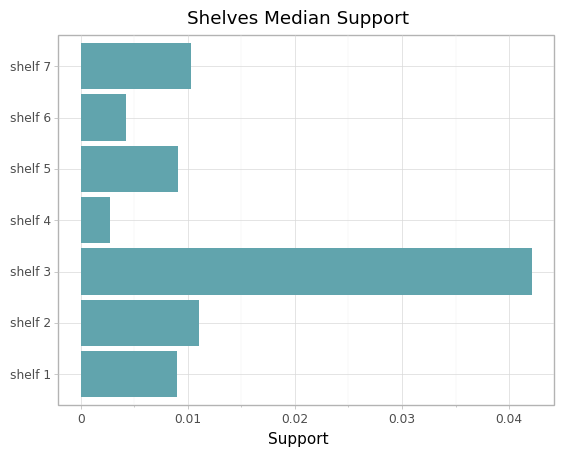

<ggplot: (8732034104777)>

In [84]:
df_plot = one_item_data[one_item_data["Type_Item_1"] == "placed"].groupby("Shelf_Item_1").median().sort_values("Support", ascending = False)
df_plot["Shelf"] = df_plot.index

(ggplot(df_plot, aes(x = "Shelf", y = "Support"))+
 geom_col(fill = "#61A4AD")+
 coord_flip()+
 labs(title = "Shelves Median Support",
     x = "")+
 theme_light()
)

When we plot for the mean value Shelves 6, 7 and 2 get closer to 3.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


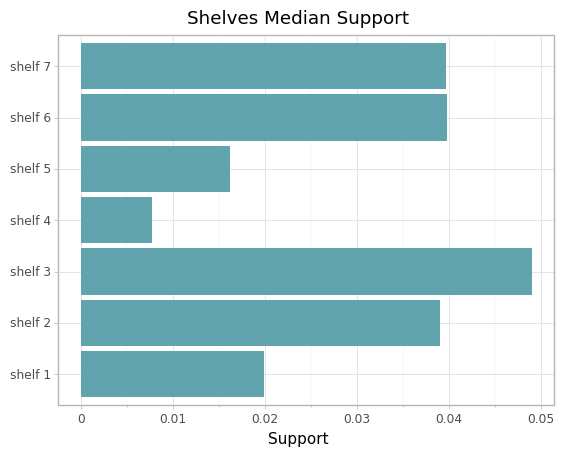

<ggplot: (8732043910605)>

In [85]:
df_plot = one_item_data[one_item_data["Type_Item_1"] == "placed"].groupby("Shelf_Item_1").mean().sort_values("Support", ascending = False)
df_plot["Shelf"] = df_plot.index

(ggplot(df_plot, aes(x = "Shelf", y = "Support"))+
 geom_col(fill = "#61A4AD")+
 coord_flip()+
 labs(title = "Shelves Median Support",
     x = "")+
 theme_light()
)

The items in each shelf have very asymmetric distribution and the mean for Shelves 6, 7 and 2 are affected by few items with very large support. Shelves 1, 5 and 4 are the least visited shelves, as they have low mean and median with low max values. This shelves will be benefit by items with Support higher than their mean.

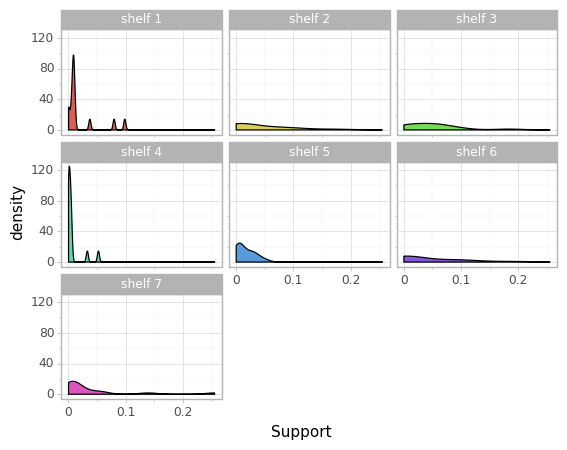

<ggplot: (8732043981809)>

In [52]:
(ggplot(one_item_data[one_item_data["Type_Item_1"] == "placed"], aes(x = "Support", fill = "Shelf_Item_1"))+
 geom_density()+
 scale_fill_discrete(guide=False)+
 facet_wrap("Shelf_Item_1")+
 theme_light()
)

Another way of comparing shelves support distribution is using boxplots. Here we compare the values for the placed items.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


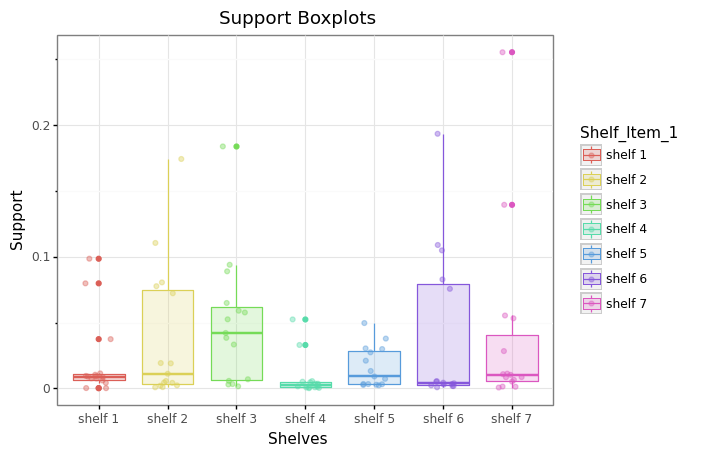

<ggplot: (8732034456133)>

In [53]:
plot_data = one_item_data[one_item_data["Type_Item_1"] == "placed"]

(ggplot(plot_data, aes(x = "Shelf_Item_1", y = "Support", color = "Shelf_Item_1", fill = "Shelf_Item_1"))+
     geom_boxplot(alpha = 0.2)+
     geom_jitter(alpha = 0.4, width = 0.2)+
     labs(title = "Support Boxplots",
         x = "Shelves",
         y = "Support")+
     theme_bw()
)

We can add the unplaced items to the boxplot analysis.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


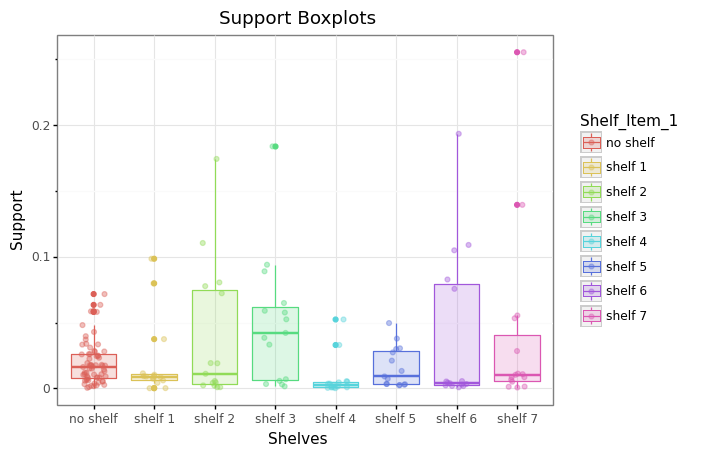

<ggplot: (8732034363869)>

In [54]:
plot_data = one_item_data

(ggplot(plot_data, aes(x = "Shelf_Item_1", y = "Support", color = "Shelf_Item_1", fill = "Shelf_Item_1"))+
     geom_boxplot(alpha = 0.2)+
     geom_jitter(alpha = 0.4, width = 0.2)+
     labs(title = "Support Boxplots",
         x = "Shelves",
         y = "Support")+
     theme_bw()
)

We can inspect which are the placed items with the biggest single item support value.

In [55]:
one_item_data[one_item_data["Type_Item_1"] == "placed"].sort_values("Support", ascending = False)

,Item_1,Frequency,Support,Type_Item_1,Shelf_Item_1
14362,whole milk,2513,0.255516,placed,shelf 7
11737,other vegetables,1903,0.193493,placed,shelf 6
504,rolls/buns,1809,0.183935,placed,shelf 3
3190,soda,1715,0.174377,placed,shelf 2
10710,yogurt,1372,0.139502,placed,shelf 7
...,...,...,...,...,...
12087,frozen chicken,6,0.000610,placed,shelf 7
9994,kitchen utensil,4,0.000407,placed,shelf 4
14155,preservation products,2,0.000203,placed,shelf 1
4069,baby food,1,0.000102,placed,shelf 4


In the next bar plot we can confirm items in shelves 1, 4 and 5 have less representation in the biggest suport.

In [56]:
df_plot1 = one_item_data[one_item_data["Type_Item_1"] == "placed"].sort_values("Support", ascending = False)

(ggplot(df_plot1.head(35), aes(x = "reorder(Item_1, +Support)", y = "Support", fill = "Shelf_Item_1"))+
     geom_col(alpha = 0.6, color = "black", width = 0.6)+
     coord_flip()+
     labs(x = "Placed Items",
         fill = "Shelf")+
     theme_light()
)

PlotnineError: ignored

### Unplaced Items Analysis

We can see the first 30 **unplaced** single items ordered descending by Support.

In [57]:
one_item_data[one_item_data["Type_Item_1"] == "unplaced"].sort_values("Support", ascending = False)

,Item_1,Frequency,Support,Type_Item_1,Shelf_Item_1
1962,whipped/sour cream,705,0.071683,unplaced,no shelf
10449,domestic eggs,624,0.063447,unplaced,no shelf
13545,margarine,576,0.058566,unplaced,no shelf
12535,coffee,571,0.058058,unplaced,no shelf
8800,frozen vegetables,473,0.048094,unplaced,no shelf
...,...,...,...,...,...
14112,tidbits,23,0.002339,unplaced,no shelf
10879,flower soil/fertilizer,19,0.001932,unplaced,no shelf
12654,organic products,16,0.001627,unplaced,no shelf
14344,rubbing alcohol,10,0.001017,unplaced,no shelf


In [58]:
df_plot1 = one_item_data[one_item_data["Type_Item_1"] == "unplaced"].sort_values("Support", ascending = False)

(ggplot(df_plot1.head(30), aes(x = "reorder(Item_1, Support)", y = "Support"))+
     geom_col(alpha = 0.6, color = "black", width = 0.6,fill = "#61A4AD")+
     coord_flip()+
     labs(x = "Unplaced Items")+
     theme_bw()
)

PlotnineError: ignored

In [59]:
df_plot1 = one_item_data[one_item_data["Type_Item_1"] == "unplaced"].sort_values("Support", ascending = False)

(ggplot(df_plot1.head(30), aes(x = "reorder(Item_1, Support)", y = "Support"))+
     geom_col(alpha = 0.6, color = "black", width = 0.6, fill = "#61A4AD")+
     coord_flip()+
     labs(x = "Unplaced Items")+
     theme_bw()
)

PlotnineError: ignored

## Two Items Analysis

In [60]:
data_complete.head()

,Item_Comb,Item_1,Item_2,n_Items,Frequency,Support,Lift,Leverage,Item_Type,Type_Item_1,Type_Item_2,Shelf_Item_1,Shelf_Item_2
0,[soft cheese],soft cheese,None,1,168,0.017082,0.000000,0.000000,[unplaced],unplaced,None,no shelf,None
1,"[soft cheese, root vegetables]",soft cheese,root vegetables,2,33,0.003355,1.802122,0.001493,"[unplaced, placed]",unplaced,placed,no shelf,shelf 6
2,"[soft cheese, baby cosmetics]",soft cheese,baby cosmetics,2,0,0.000000,0.000000,-0.000010,"[unplaced, placed]",unplaced,placed,no shelf,shelf 4
3,"[soft cheese, rolls/buns]",soft cheese,rolls/buns,2,53,0.005389,1.715151,0.002247,"[unplaced, placed]",unplaced,placed,no shelf,shelf 3
4,"[soft cheese, candy]",soft cheese,candy,2,5,0.000508,0.995607,-0.000002,"[unplaced, placed]",unplaced,placed,no shelf,shelf 5


We can see that the **data_complete** and **two_item_data** were built to have each item combination just one. This way, for two item combination we should have the following combinatorial number:

$$\binom{169}{2}=14196$$


In [61]:
two_item_data = (data_complete[data_complete["n_Items"]==2].
                 drop(["Item_Comb","n_Items", "Item_Type"], axis = 1))
two_item_data

,Item_1,Item_2,Frequency,Support,Lift,Leverage,Type_Item_1,Type_Item_2,Shelf_Item_1,Shelf_Item_2
1,soft cheese,root vegetables,33,0.003355,1.802122,0.001493,unplaced,placed,no shelf,shelf 6
2,soft cheese,baby cosmetics,0,0.000000,0.000000,-0.000010,unplaced,placed,no shelf,shelf 4
3,soft cheese,rolls/buns,53,0.005389,1.715151,0.002247,unplaced,placed,no shelf,shelf 3
4,soft cheese,candy,5,0.000508,0.995607,-0.000002,unplaced,placed,no shelf,shelf 5
5,soft cheese,specialty bar,9,0.000915,1.958643,0.000448,unplaced,placed,no shelf,shelf 5
...,...,...,...,...,...,...,...,...,...,...
14357,tea,whole milk,16,0.001627,1.647852,0.000640,placed,placed,shelf 6,shelf 7
14358,tea,toilet cleaner,0,0.000000,0.000000,-0.000003,placed,placed,shelf 6,shelf 4
14360,softener,whole milk,21,0.002135,1.521975,0.000732,placed,placed,shelf 4,shelf 7
14361,softener,toilet cleaner,0,0.000000,0.000000,-0.000004,placed,placed,shelf 4,shelf 4


We create a function to generate a new column to show the number of unplaced items in the combination.

In [62]:
def unplaced_func(col1, col2):
    if (col1 == "unplaced") & (col2 == "unplaced"):
        return 2
    elif (col1 == "unplaced") | (col2 == "unplaced"):
        return 1
    else:
        return 0

In [63]:
two_item_data["n_unplaced"] = two_item_data.apply(lambda x: unplaced_func(x["Type_Item_1"], x["Type_Item_2"]), axis = 1)
two_item_data

,Item_1,Item_2,Frequency,Support,Lift,Leverage,Type_Item_1,Type_Item_2,Shelf_Item_1,Shelf_Item_2,n_unplaced
1,soft cheese,root vegetables,33,0.003355,1.802122,0.001493,unplaced,placed,no shelf,shelf 6,1
2,soft cheese,baby cosmetics,0,0.000000,0.000000,-0.000010,unplaced,placed,no shelf,shelf 4,1
3,soft cheese,rolls/buns,53,0.005389,1.715151,0.002247,unplaced,placed,no shelf,shelf 3,1
4,soft cheese,candy,5,0.000508,0.995607,-0.000002,unplaced,placed,no shelf,shelf 5,1
5,soft cheese,specialty bar,9,0.000915,1.958643,0.000448,unplaced,placed,no shelf,shelf 5,1
...,...,...,...,...,...,...,...,...,...,...,...
14357,tea,whole milk,16,0.001627,1.647852,0.000640,placed,placed,shelf 6,shelf 7,0
14358,tea,toilet cleaner,0,0.000000,0.000000,-0.000003,placed,placed,shelf 6,shelf 4,0
14360,softener,whole milk,21,0.002135,1.521975,0.000732,placed,placed,shelf 4,shelf 7,0
14361,softener,toilet cleaner,0,0.000000,0.000000,-0.000004,placed,placed,shelf 4,shelf 4,0


In [64]:
# Multiplying factor for Support and Leverage Scores
p_sup = 100
p_lev = 500

In [65]:
(one_item_data.
 query('Type_Item_1 == "placed"').
 assign(Support_Score = one_item_data["Support"] * p_sup).
 groupby("Shelf_Item_1").
 agg({"Support_Score": ["mean", "median", "min", "max", "sum"]})
)

Support_Score                                          
                      mean    median       min        max        sum
Shelf_Item_1                                                        
shelf 1           1.994916  0.894764  0.010168   9.852567  29.923742
shelf 2           3.899678  1.108287  0.081342  17.437722  58.495170
shelf 3           4.899509  4.209456  0.152517  18.393493  73.492628
shelf 4           0.770717  0.274530  0.010168   5.236401  11.560752
shelf 5           1.619387  0.904931  0.233859   4.961871  24.290798
shelf 6           3.982376  0.427046  0.081342  19.349263  59.735638
shelf 7           3.973564  1.026945  0.061007  25.551601  59.603457

In [66]:
shelves_sup = (one_item_data.
 query('Type_Item_1 == "placed"').
 assign(Support_Score = one_item_data["Support"] * p_sup).
 groupby("Shelf_Item_1").
 agg({"Support_Score": "sum"})
)

shelves_lev = (two_item_data.
 query('n_unplaced == 0').
 query('Shelf_Item_1 == Shelf_Item_2').
 assign(Leverage_Score = two_item_data["Leverage"] * p_lev).
 groupby("Shelf_Item_1").
 agg({"Leverage_Score":"sum"})
)

In [67]:
shelves_score = pd.DataFrame({"Shelf":shelves_sup.index,
                             "Support_Score":shelves_sup["Support_Score"],
                             "Leverage_Score": shelves_lev["Leverage_Score"]})

shelves_score = (shelves_score.
                 assign(Total_Score = shelves_score["Support_Score"] + shelves_score["Leverage_Score"]))

shelves_score

,Shelf,Support_Score,Leverage_Score,Total_Score
Shelf_Item_1,,,,
shelf 1,shelf 1,29.923742,4.179976,34.103718
shelf 2,shelf 2,58.495170,23.885928,82.381098
shelf 3,shelf 3,73.492628,56.444569,129.937197
shelf 4,shelf 4,11.560752,4.761751,16.322504
shelf 5,shelf 5,24.290798,14.059594,38.350392
shelf 6,shelf 6,59.735638,70.328566,130.064204
shelf 7,shelf 7,59.603457,46.291848,105.895305


In [81]:
(ggplot(shelves_score, aes(x = "reorder(Shelf, +Total_Score)", y = "Total_Score"))+
 geom_col(fill = "#61A4AD")+
 theme_light()
)

PlotnineError: ignored

In [69]:
unplaced_data = (one_item_data.
 query('Type_Item_1 == "unplaced"').
 assign(Support_Score = one_item_data["Support"] * p_sup).
 filter(["Item_1", "Support_Score"])
)
unplaced_data

,Item_1,Support_Score
0,soft cheese,1.708185
1485,packaged fruit/vegetables,1.301474
1804,processed cheese,1.657346
1962,whipped/sour cream,7.168277
2119,frozen fish,1.169293
...,...,...
14245,dessert,3.711235
14260,canned vegetables,1.077783
14274,UHT-milk,3.345196
14287,female sanitary products,0.610066


In [70]:
index = []
shelf_lev = np.zeros([64, 7])
lev_shelf = np.zeros(15)
i = 0

for unplaced in unplaced_items:
    index.append(unplaced)
    j = 0
    for shelf in shelves:
        k = 0
        for placed in shelf:
            lev_shelf[k] = data_leverage.loc[unplaced, placed] * p_lev
            k = k + 1
        shelf_lev[i, j] = np.sum(np.array(lev_shelf))
        j = j + 1
    i = i + 1
shelf_lev = pd.DataFrame(shelf_lev)
leverage_cols = ["Lev_Score_S1", "Lev_Score_S2", "Lev_Score_S3", "Lev_Score_S4", "Lev_Score_S5", "Lev_Score_S6", "Lev_Score_S7"]
shelf_lev.columns = leverage_cols
shelf_lev["Lev_Max"] = shelf_lev[leverage_cols].idxmax(axis=1)
shelf_lev["Lev_Min"] = shelf_lev[leverage_cols].idxmin(axis=1)
shelf_lev = shelf_lev.assign(Item_1 = index)
shelf_lev


,Lev_Score_S1,Lev_Score_S2,Lev_Score_S3,Lev_Score_S4,Lev_Score_S5,Lev_Score_S6,Lev_Score_S7,Lev_Max,Lev_Min,Item_1
0,1.867215,0.392888,5.721016,0.436092,1.280705,5.218308,5.992181,Lev_Score_S7,Lev_Score_S2,soft cheese
1,0.137143,0.311448,2.334999,0.162798,0.147828,1.959247,1.256104,Lev_Score_S3,Lev_Score_S1,packaged fruit/vegetables
2,0.824825,2.219261,5.907830,0.668834,1.800000,4.810926,3.042520,Lev_Score_S3,Lev_Score_S4,processed cheese
3,4.475731,-1.748396,10.669902,3.939842,3.291808,20.684482,20.528502,Lev_Score_S6,Lev_Score_S2,whipped/sour cream
4,0.995816,-0.623764,2.414005,0.493398,1.172627,3.777530,3.226031,Lev_Score_S6,Lev_Score_S2,frozen fish
...,...,...,...,...,...,...,...,...,...,...
59,3.445772,2.821181,7.765730,1.616841,3.169221,7.013977,7.496054,Lev_Score_S3,Lev_Score_S4,dessert
60,0.268471,0.558979,2.038526,0.597133,0.978737,4.254206,2.176936,Lev_Score_S6,Lev_Score_S1,canned vegetables
61,2.010721,2.671626,3.671035,0.862487,0.817655,4.141828,0.300184,Lev_Score_S6,Lev_Score_S7,UHT-milk
62,0.764909,0.045902,0.503529,0.664136,0.580860,0.821485,0.927195,Lev_Score_S7,Lev_Score_S2,female sanitary products


In [71]:
unplaced_data = unplaced_data.merge(shelf_lev, how = "left", on = "Item_1")
unplaced_data.sort_values("Support_Score", ascending = False)

,Item_1,Support_Score,Lev_Score_S1,Lev_Score_S2,Lev_Score_S3,Lev_Score_S4,Lev_Score_S5,Lev_Score_S6,Lev_Score_S7,Lev_Max,Lev_Min
3,whipped/sour cream,7.168277,4.475731,-1.748396,10.669902,3.939842,3.291808,20.684482,20.528502,Lev_Score_S6,Lev_Score_S2
28,domestic eggs,6.344687,4.335325,2.541441,14.306355,3.195776,2.512731,16.992863,16.068858,Lev_Score_S6,Lev_Score_S5
47,margarine,5.856634,3.540379,2.545390,12.134340,2.206917,1.631164,12.553265,11.778550,Lev_Score_S6,Lev_Score_S5
39,coffee,5.805796,4.887414,1.626466,4.746166,1.677077,1.794588,4.469217,5.727720,Lev_Score_S7,Lev_Score_S2
24,frozen vegetables,4.809354,3.480463,1.744679,7.899332,2.608929,1.937190,13.240998,12.662717,Lev_Score_S6,Lev_Score_S2
...,...,...,...,...,...,...,...,...,...,...,...
55,tidbits,0.233859,0.005976,0.383636,0.869176,0.017337,0.326035,0.114937,0.421515,Lev_Score_S3,Lev_Score_S1
31,flower soil/fertilizer,0.193188,0.168505,-0.259994,-0.354021,0.091686,-0.183795,-0.271976,-0.372377,Lev_Score_S1,Lev_Score_S7
40,organic products,0.162684,0.214143,0.083415,0.622327,0.210995,0.310802,0.683391,0.176078,Lev_Score_S6,Lev_Score_S2
63,rubbing alcohol,0.101678,0.102065,0.109328,0.134760,0.347937,0.130703,0.763927,0.357888,Lev_Score_S6,Lev_Score_S1


We can see how most unplaced items have biggest leverage score value with the items in shelves 3, 6 and 7. This can be helpful, as it means that unplaced items are generally positively correlated with this shelves (3,6,7) that already have a high total score. The unplaced items with the highest support score can be assigned to the shelves with lowest total score (1,4,5) and will keep high correlation with the most visited shelves.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


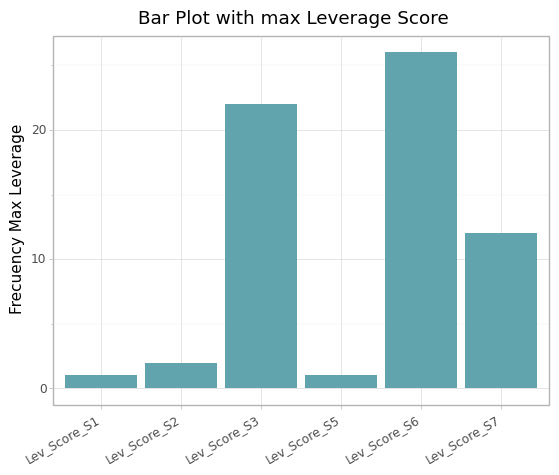

<ggplot: (8732034073865)>

In [72]:
(ggplot(unplaced_data, aes(x = "Lev_Max"))+
 geom_bar(fill = "#61A4AD")+
 labs(title = "Bar Plot with max Leverage Score",
     x = "",
     y = "Frecuency Max Leverage")+
 theme_light()+
 theme(axis_text_x=element_text(rotation=30, hjust=1))
)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


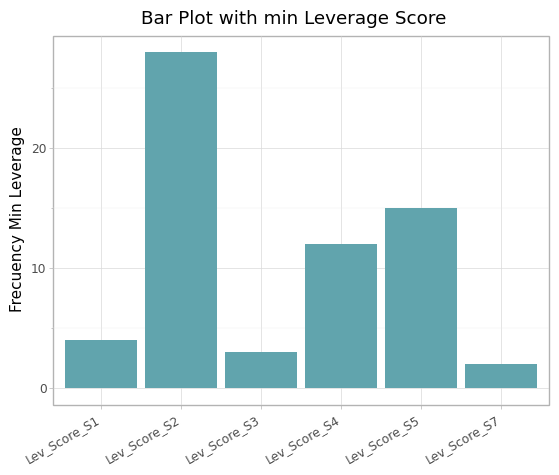

<ggplot: (8732034145321)>

In [73]:
(ggplot(unplaced_data, aes(x = "Lev_Min"))+
 geom_bar(fill = "#61A4AD")+
 labs(title = "Bar Plot with min Leverage Score",
     x = "",
     y = "Frecuency Min Leverage")+
 theme_light()+
 theme(axis_text_x=element_text(rotation=30, hjust=1))
)

In [74]:
unplaced_data

,Item_1,Support_Score,Lev_Score_S1,Lev_Score_S2,Lev_Score_S3,Lev_Score_S4,Lev_Score_S5,Lev_Score_S6,Lev_Score_S7,Lev_Max,Lev_Min
0,soft cheese,1.708185,1.867215,0.392888,5.721016,0.436092,1.280705,5.218308,5.992181,Lev_Score_S7,Lev_Score_S2
1,packaged fruit/vegetables,1.301474,0.137143,0.311448,2.334999,0.162798,0.147828,1.959247,1.256104,Lev_Score_S3,Lev_Score_S1
2,processed cheese,1.657346,0.824825,2.219261,5.907830,0.668834,1.800000,4.810926,3.042520,Lev_Score_S3,Lev_Score_S4
3,whipped/sour cream,7.168277,4.475731,-1.748396,10.669902,3.939842,3.291808,20.684482,20.528502,Lev_Score_S6,Lev_Score_S2
4,frozen fish,1.169293,0.995816,-0.623764,2.414005,0.493398,1.172627,3.777530,3.226031,Lev_Score_S6,Lev_Score_S2
...,...,...,...,...,...,...,...,...,...,...,...
59,dessert,3.711235,3.445772,2.821181,7.765730,1.616841,3.169221,7.013977,7.496054,Lev_Score_S3,Lev_Score_S4
60,canned vegetables,1.077783,0.268471,0.558979,2.038526,0.597133,0.978737,4.254206,2.176936,Lev_Score_S6,Lev_Score_S1
61,UHT-milk,3.345196,2.010721,2.671626,3.671035,0.862487,0.817655,4.141828,0.300184,Lev_Score_S6,Lev_Score_S7
62,female sanitary products,0.610066,0.764909,0.045902,0.503529,0.664136,0.580860,0.821485,0.927195,Lev_Score_S7,Lev_Score_S2


In [80]:
assigned_shelf = [0]*64
leverage_score = [0]*64
ps1 = 1
ps2 = 1.25
ps3 = 0.2
ps4 = 1.5
ps5 = 1.10
ps6 = 0.15
ps7 = 0.2
shelf_name = np.array(["shelf1", "shelf2", "shelf3", "shelf4", "shelf5", "shelf6", "shelf7"])
shelf_n_items = np.zeros(7)
pond = np.array([ps1, ps2, ps3, ps4, ps5, ps6, ps7])
Lev_Scores = (unplaced_data.
              sort_values("Support_Score", ascending = False).
              filter(["Lev_Score_S1", "Lev_Score_S2", "Lev_Score_S3", "Lev_Score_S4", "Lev_Score_S5", "Lev_Score_S6", "Lev_Score_S7"]).
              to_numpy())

for i in range(unplaced_data.shape[0]):
    ordered_values = np.flip((Lev_Scores[i]*pond).argsort())
    for j in ordered_values:
        if shelf_n_items[j] < 10:
            assigned_shelf[i] = shelf_name[j]
            leverage_score[i] = Lev_Scores[i,j]
            shelf_n_items[j] = shelf_n_items[j] + 1
            break

assigned_shelf

(ggplot(aes(x = assigned_shelf))+
 geom_bar(color = "black")
)

AttributeError: ignored

In [76]:
unplaced_data = unplaced_data.assign(Shelf = assigned_shelf,
                                     Leverage_Score = leverage_score)
unplaced_data = unplaced_data.assign(Total_Score = unplaced_data["Support_Score"]+ unplaced_data["Leverage_Score"])

In [77]:
unplaced_data.head()

,Item_1,Support_Score,Lev_Score_S1,Lev_Score_S2,Lev_Score_S3,Lev_Score_S4,Lev_Score_S5,Lev_Score_S6,Lev_Score_S7,Lev_Max,Lev_Min,Shelf,Leverage_Score,Total_Score
0,soft cheese,1.708185,1.867215,0.392888,5.721016,0.436092,1.280705,5.218308,5.992181,Lev_Score_S7,Lev_Score_S2,shelf4,3.939842,5.648027
1,packaged fruit/vegetables,1.301474,0.137143,0.311448,2.334999,0.162798,0.147828,1.959247,1.256104,Lev_Score_S3,Lev_Score_S1,shelf4,3.195776,4.497250
2,processed cheese,1.657346,0.824825,2.219261,5.907830,0.668834,1.800000,4.810926,3.042520,Lev_Score_S3,Lev_Score_S4,shelf1,3.540379,5.197725
3,whipped/sour cream,7.168277,4.475731,-1.748396,10.669902,3.939842,3.291808,20.684482,20.528502,Lev_Score_S6,Lev_Score_S2,shelf1,4.887414,12.055691
4,frozen fish,1.169293,0.995816,-0.623764,2.414005,0.493398,1.172627,3.777530,3.226031,Lev_Score_S6,Lev_Score_S2,shelf4,2.608929,3.778223


In [78]:
(unplaced_data.
 groupby("Shelf").
 agg({"Total_Score":["sum","count"]})
)

Total_Score      
               sum count
Shelf                   
shelf1   45.652617    10
shelf2   34.386555    10
shelf3   42.175143    10
shelf4   33.438156    10
shelf5   41.662355    10
shelf6   28.771569     7
shelf7   19.564792     7

In [79]:
Lev_Scores = (unplaced_data.
              sort_values("Support_Score", ascending = False).
              filter(["Lev_Score_S1", "Lev_Score_S2", "Lev_Score_S3", "Lev_Score_S4", "Lev_Score_S5", "Lev_Score_S6", "Lev_Score_S7"]).
              to_numpy())
print(Lev_Scores[1])
print((Lev_Scores[1]*pond))
print(shelf_name)
print(shelf_name[tuple([np.flip((Lev_Scores[1]*pond).argsort())])])
print(tuple([np.flip((Lev_Scores[1]*pond).argsort())]))
np.flip((Lev_Scores[i]*pond).argsort())

[ 4.33532545  2.54144063 14.3063548   3.19577554  2.51273103 16.99286318
 16.06885755]
[4.33532545 3.17680079 2.86127096 4.79366331 2.76400414 2.54892948
 3.21377151]
['shelf1' 'shelf2' 'shelf3' 'shelf4' 'shelf5' 'shelf6' 'shelf7']
['shelf4' 'shelf1' 'shelf7' 'shelf2' 'shelf3' 'shelf5' 'shelf6']
(array([3, 0, 6, 1, 2, 4, 5]),)


array([3, 6, 2, 5, 4, 0, 1])